In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funcs.geometry import create_spherical_grid, set_up_oblique_auroral_ring, rotate_around_arb_axis, calculate_surface_element_velocities

from astropy.constants import R_sun

# dark background
plt.style.use('dark_background')

def get_v_bounds(X, Y, Z):

    phi_where_v_turns = [np.arctan(Y/Z)]

    if phi_where_v_turns[0] < np.pi:
        phi_where_v_turns.append(np.arctan(Y/Z) + np.pi)
    elif phi_where_v_turns[0] > np.pi:
        phi_where_v_turns.append(np.arctan(Y/Z) - np.pi)

    for i in range(2):
        if phi_where_v_turns[i] < 0:
            print("phi < 0")
            phi_where_v_turns[i] = phi_where_v_turns[i] + 2 * np.pi
        elif phi_where_v_turns[i] > 2 * np.pi:
            print("phi > 2pi")
            phi_where_v_turns[i] = phi_where_v_turns[i] - 2 * np.pi

    zero_v = v_phi(phi_where_v_turns, X, Y, Z)    

    signum = np.sign( - np.sin(phi_where_v_turns) * Y - np.cos(phi_where_v_turns) * Z)
    
    return phi_where_v_turns, zero_v, signum

def get_phi_bounds(phi, A, B, C, X, Y, Z):

    a, b = B/A, C/A

    bounds = []
    for n in range(-2, 3):

        _ = a**2 + b**2 - 1 
        
        if _ > 0:
            b1 = 2 * (np.arctan((a - np.sqrt(_)) / (b - 1)) + n * np.pi)
            if (b1 > 0) & (b1 < 2 * np.pi):
                bounds.append(b1)
            b2 = 2 * (np.arctan((a + np.sqrt(a**2 + b**2 - 1)) / (b - 1)) + n * np.pi)
            if (b2 > 0) & (b2 < 2 * np.pi):
                bounds.append(b2)

    # derivative of the function gets us which side of the bound to include
    bounds = np.sort(np.array(bounds))

    # get the derivative dx/dphi
    dx_dphi_at_bounds = np.sign(dx_dphi(bounds, B, C))

    # print(bounds, dx_dphi_at_bounds)

    def bounds_mask(phi):

        default = (phi < 2 * np.pi) & (phi > 0)
        mark = 1 # we start inclusive 

        for bound, dx_dphi_at_bound in zip(bounds, dx_dphi_at_bounds):

            if dx_dphi_at_bound == 1:

                if mark == 1:
                    # print("1")
                    default = default & (phi >bound)
                    mark = 1
                    # print("We are already inclusive, but the slope is positive, "
                    #       "so we must be at the beginning of the full interval")

                elif mark == 0:
                    # print("2")
                    default = default | (phi > bound)
                    mark = 1
                    # print("The slope has been negative, changes to positive, "
                    #       "so we must be at the beginning of an included interval")

            elif dx_dphi_at_bound == -1:

                if mark == 1:
                    # print("3")
                    default = default & (phi < bound)
                    mark = 0
                    # print("We are already inclusive, but the slope is negative, "
                    #       "so we must be at the end of the included interval.")

                elif mark == 0:
                    raise ValueError('negative slope although we already have a negative slope')

        return default
    
    bounds_v = v_phi(bounds, X, Y, Z)

    return bounds, bounds_v, dx_dphi_at_bounds, bounds_mask(phi)


def x_params(alpha, i_rot, i_mag, latitude):
    sa, ca = np.sin(alpha), np.cos(alpha)
    si, ci = np.sin(i_rot), np.cos(i_rot)
    st, ct = np.sin(latitude), np.cos(latitude)
    # sp, cp = np.sin(phi), np.cos(phi)
    sip, cip = np.sin(i_rot + i_mag), np.cos(i_rot + i_mag)
    Ca = 1 - np.cos(alpha)


    A = ct * sip * (ca + si**2 * Ca) + ct * cip *ci * si * Ca
    B = cip * st  * (ca + si**2 * Ca) - sip * st * ci * si * Ca
    C = - sa * ci * st

    return A, B, C

def vx_params(alpha, i_rot, i_mag, latitude):
    sa, ca = np.sin(alpha), np.cos(alpha)
    si, ci = np.sin(i_rot), np.cos(i_rot)
    st, ct = np.sin(latitude), np.cos(latitude)
    # sp, cp = np.sin(phi), np.cos(phi)
    sip, cip = np.sin(i_rot + i_mag), np.cos(i_rot + i_mag)

    X = -sa * (sip * ct - ct * sip * si**2 - ct * cip * si * ci)
    Y = -sa * cip *st + sa * cip * st * si**2 - sa * sip * st * ci *si
    Z = -ca * ci * st

    return X, Y, Z



def v_phi(phi, X, Y, Z):
    return Y * np.sin(phi) + Z * np.cos(phi) + X


def flux_at_x_vx(vx, x, X, Y, Z):

    flux = 1/ np.sqrt(-(vx - X)**2 + Y**2 + Z**2 + .25) *np.cos(np.pi/2 - np.arcsin(x))

    # flux[flux>10] = 10

    return flux


def phi_v(v, X, Y, Z):
    n, m = 1, 0
    phi1 = 2 * (np.arctan((Y - np.sqrt(-v**2 + 2 * v * X - X**2 + Y**2 + Z**2)) / (v - X + Z) ) + n * np.pi)
    phi2 = 2 * (np.arctan((Y + np.sqrt(-v**2 + 2 * v * X - X**2 + Y**2 + Z**2)) / (v - X + Z) ) + m * np.pi)

    return phi1, phi2

def x_phi(phi, A, B, C):
    return B * np.sin(phi) + C * np.cos(phi) + A

def dx_dphi(phi, B, C):
    return B * np.cos(phi) - C * np.sin(phi)


def get_spectral_line(phi, i_rot, i_mag, latitude, alpha):

    A, B, C = x_params(alpha, i_rot=i_rot, i_mag=i_mag, latitude=np.pi/2 - latitude)

    X, Y, Z = vx_params(alpha, i_rot=i_rot, i_mag=i_mag, latitude=np.pi/2 - latitude)

    v = v_phi(phi, X, Y, Z)
    x = x_phi(phi, A, B, C)

    phi_bounds, phi_bounds_v, signum, mask = get_phi_bounds(phi, A, B, C, X, Y, Z)

    phi_bounds = np.insert(phi_bounds, 0, 0)
    phi_bounds = np.insert(phi_bounds, -1, 2*np.pi)

    # add phi_bounds_v
    phi_bounds_v = np.insert(phi_bounds_v, 0, v_phi(0, X, Y, Z))
    phi_bounds_v = np.insert(phi_bounds_v, -1, v_phi(2* np.pi, X, Y, Z))

    # add signum
    signum = np.insert(signum, 0, np.sign(dx_dphi(phi_bounds[0], B, C)))
    signum = np.insert(signum, -1, np.sign(dx_dphi(phi_bounds[-1], B, C)))

    # v_bounds
    v_bounds_phi, v_bounds, signum_v = get_v_bounds(X, Y, Z)

    assert v_bounds.shape[0] == 2

    flux = flux_at_x_vx(v, x, X, Y, Z)

    # make flux_mask from mask
    fluxmask = np.copy(mask).astype(int)

    _vb, _vbp, _sv = np.copy(v_bounds), np.copy(v_bounds_phi), np.copy(signum_v)


    # rebin flux and v
    # first make a pandas dataframe
    df = pd.DataFrame({'phi': phi, 'v': v, 'flux': flux})

    df = df.sort_values(by=['v'], ascending=True)

    bins = np.linspace(-2,2, 60)

    # bin in v and sum the flux
    df_v = df.groupby(pd.cut(df['v'], bins=bins)).sum()

    # get the midpoints of the bins
    v_mids = pd.IntervalIndex(df_v.index).mid.values



    # get the flux at the midpoints
    flux = df_v['flux'].values

    # for i in range(1,len(phi_bounds)):

    #     # print(phi_bounds[i], v_bounds_phi[0], signum_v[0])

    #     try:
    #         print(phi_bounds[i], v_bounds_phi[0], signum_v[0])
    
    #         if (phi_bounds[i] > v_bounds_phi[0]) & (signum_v[0] == -1): # maximum
    #             phi_rel_on = (phi > phi_bounds[i-1]) & (phi < v_bounds_phi[0])
    #             phi_rel_off = (phi < phi_bounds[i]) & (phi > v_bounds_phi[0])
    #             pos_diff = (v_bounds[0] > phi_bounds_v)
    #             next_v_level = np.argmin(v_bounds[0] - phi_bounds_v[pos_diff])
    #             between_v = (v > phi_bounds_v[pos_diff][next_v_level]) & (v < v_bounds[0])
    #             fluxmask[phi_rel_on & between_v] = 2
    #             fluxmask[phi_rel_off & between_v] = 0
    #             print("maximum")

    #             # delete v_bounds_phi[0], signum_v[0] and v_bounds[0] from their arrays
    #             v_bounds_phi = np.delete(v_bounds_phi, 0)
    #             signum_v = np.delete(signum_v, 0)
    #             v_bounds = np.delete(v_bounds, 0)

    #         if (phi_bounds[i] > v_bounds_phi[0]) & (signum_v[0] == 1): # minimum
    #             phi_rel_on = (phi > phi_bounds[i-1]) & (phi < v_bounds_phi[0])
    #             phi_rel_off = (phi < phi_bounds[i]) & (phi > v_bounds_phi[0])
    #             pos_diff = (v_bounds[0] < phi_bounds_v)

    #             print(pos_diff)
    #             next_v_level = np.argmin(phi_bounds_v[pos_diff] - v_bounds[0])
    #             between_v = (v > v_bounds[0]) & (v < phi_bounds_v[pos_diff][next_v_level])
    #             fluxmask[phi_rel_on & between_v] = 2
    #             fluxmask[phi_rel_off & between_v] = 0
    #             print("minimum")

    #             # delete v_bounds_phi[0], signum_v[0] and v_bounds[0] from their arrays
    #             v_bounds_phi = np.delete(v_bounds_phi, 0)
    #             signum_v = np.delete(signum_v, 0)
    #             v_bounds = np.delete(v_bounds, 0)

    #     except IndexError:
    #         pass
    return phi_bounds, phi_bounds_v, signum, _vbp, _vb, flux, fluxmask, mask, v_mids, phi, A, B, C



No handles with labels found to put in legend.


(566,)
(1594,)
phi < 0
[5.62814399 2.48655134] [0.         2.34354008 6.28318531 4.58371795]
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  10.04298842  -2.48574133  -7.05108866 -10.64704676 -14.99827118
 -19.56916194 -25.79029101 -38.29621323 -79.58075515 -44.40460692
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]


/tmp/ipykernel_120954/3495143370.py:202: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_v = df.groupby(pd.cut(df['v'], bins=bins)).sum()


(0.0, 6.283185307179586)

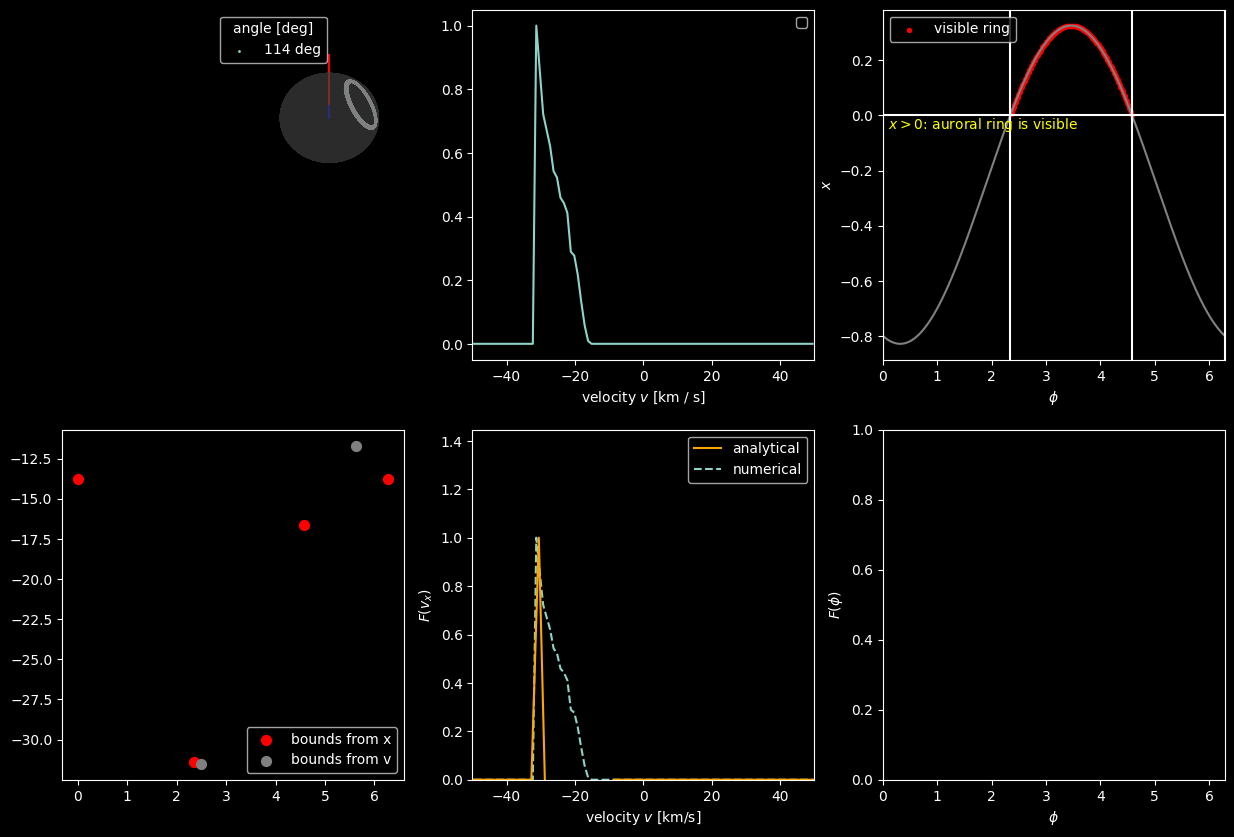

In [150]:
# --- SET UP the numerical solution

THETA, PHI = create_spherical_grid(int(1e5))
# input parameters

# rotation period in days
P_rot = 0.5 * np.pi

# stellar radius in solar radii
Rstar = 1.

# upper latitude of ring around magnetic axis in radians
PHI_max = 54 * np.pi/180

# lower latitude of ring around magnetic axis in radians
PHI_min = 51 * np.pi/180

# lower latitude must be smaller than upper latitude
assert PHI_min < PHI_max

# convert dxr_visible from km/s to nm using speed of light
# and wavelength of the line
c = 299792.458 # km/s
wavelength = 3825.4 # AA Ca II H line
bins = np.linspace(-1,1,200)

#  SET UP the analytical solution

phi = np.linspace(0, 2*np.pi, 500)

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 80 * np.pi/180

# inclination of magnetic axis in radians relative to rotation axis
i_mag = 70 * np.pi/180

# latitude of the ring in radians
latitude = (PHI_max + PHI_min) / 2


# phase
alpha = 114 * np.pi/180

### -------

# NUMERICAL solution

(x, y, z), z_rot, z_rot_mag = set_up_oblique_auroral_ring(THETA, PHI, PHI_max, PHI_min, i_rot, i_mag)

# FIGURE SETUP

# set up a figure with six panels in a 3x2 grid, the first panel is in 3d projection
fig, axes = plt.subplots(2,3,figsize=(15, 10))
axes = axes.flatten()

# add the 3d projection to the top panel
ax = fig.add_subplot(321, projection='3d')

axes[0].set_axis_off()

ax2 = axes[1]

ax3 = axes[2]

ax4 = axes[3]

ax5 = axes[4]

ax6 = axes[5]

# THE SPHERE

ax.scatter(np.sin(THETA)*np.cos(PHI),
              np.sin(THETA)*np.sin(PHI),
              np.cos(THETA), c='grey', alpha=0.01)

# ax.scatter(x, y, z, alpha=1)

# plot the x axis as a dashed line
ax.plot([-1, 1], [0, 0], [0, 0], c='w', ls='--')


# plot z_rot
ax.plot([0, 1.5 *z_rot[0]], [0, 1.5 *z_rot[1]], [0,1.5 * z_rot[2]], c='r')


# plot z_rot_mag
ax.plot([0, z_rot_mag[0]], [0, z_rot_mag[1]], [0, z_rot_mag[2]], c='b')



xr, yr, zr = rotate_around_arb_axis(alpha, np.array([x, y, z]), z_rot)

# plot the rotated blue points
ax.scatter(xr, yr, zr, alpha=1, label=f'{alpha*180/np.pi:.0f} deg', s=1)


# select only the positive values of xr
q = xr > 0

# sum over the positive values of xr
flux_numerical = np.sum(xr[q])


# set figure limits to -1.5 to 1.5 on eacha xis
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.3, 1.2)

# label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# rotate the figure such that x-axis point towards me
ax.view_init(0, 0)

# legend
ax.legend(title='angle [deg]', loc='upper left', ncol=2)

# let axes disappear
ax.set_axis_off()


# SPECTRAL LINE


# angular velocity in rad/d
omega = 2 * np.pi / P_rot

# make small angle in rad
dalpha = 1 * np.pi/180


bins = np.linspace(-50,50,100)
binmids = (bins[1:] + bins[:-1])/2


dxr_visible = calculate_surface_element_velocities(alpha, dalpha, x, y, z, z_rot, omega, Rstar)

print(dxr_visible.shape)
print(xr.shape)
hist, bins = np.histogram(dxr_visible, bins=bins, weights=np.cos(np.pi/2 - np.arcsin(xr[q])))

histerr = np.sqrt(hist) / np.max(hist)

hist = hist / np.max(hist)


# make a histogram of the derivative of xr
ax2.plot(binmids, hist)


ax2.set_xlabel(r'velocity $v$ [km / s]')
ax2.set_ylabel(r'$F (v)$')
ax2.set_xlim(-50, 50)
ax2.legend()


# add another four axes to fig to the right in a 2x2 grid for the analytical solution
# ax3 = fig.add_subplot(311)

# ax4 = fig.add_subplot(224)
# ax5 = fig.add_subplot(225)
# ax6 = fig.add_subplot(226)



# ANALYTICAL solution FIGURE


res = get_spectral_line(phi, i_rot, i_mag, latitude, alpha)
        
phi_bounds, phi_bounds_v, signum, v_bounds_phi, v_bounds, flux_analytical, fluxmask, mask, v, phi, A, B, C = res

print(v_bounds_phi, phi_bounds)

# convert to stellar radii / s
v_kms = v * omega / (24*3600)
    
# convert to km/s
v_kms = (v_kms * Rstar * R_sun).value / 1e3 

v_bounds_kms = v_bounds * omega / (24*3600)
v_bounds_kms = (v_bounds_kms * Rstar * R_sun).value / 1e3

phi_bounds_v_kms = phi_bounds_v * omega / (24*3600)
phi_bounds_v_kms = (phi_bounds_v_kms * Rstar * R_sun).value / 1e3

ax3.plot(phi, x_phi(phi, A, B, C), c="grey")
ax3.axhline(0, color='w')


ax3.scatter(phi[mask], x_phi(phi, A, B, C)[mask], color='r', s=8, label="visible ring")

for bs in phi_bounds:
    # print(bs)
    ax3.axvline(bs, color='w')


ax3.set_xlim(0, 2*np.pi)
ax3.set_xlabel(r'$\phi$')
ax3.set_ylabel(r'$x$')
ax3.legend()

# add text to the plot that indicates that for x>0 the auroral ring is visible
ax3.text(0.1, -0.05, r'$x>0$: auroral ring is visible', color='yellow', fontsize=10)

# phi_mids = (phi[1:] + phi[:-1])/2
# ax4.plot(phi_mids, v_kms)
# ax4.set_xlabel(r'$\phi$')
# ax4.set_ylabel(r'velocity $v$ [km/s]')
# ax4.set_xlim(0, 2*np.pi)

ax4.scatter(phi_bounds, phi_bounds_v_kms, color='r', s=50, label="bounds from x")
ax4.scatter(v_bounds_phi, v_bounds_kms, color='grey', s=50, label="bounds from v")
ax4.legend()


f = flux_analytical#*fluxmask

print(f)
# f[fluxmask==0] = 0
f = f / np.max(f)

ax5.plot(v_kms, f, c="orange", 
                label="analytical")#, s=1)
ax5.plot(binmids, hist, zorder=-10, linestyle="--", label="numerical")
ax5.set_xlabel(r'velocity $v$ [km/s]')
ax5.set_ylabel(r'$F(v_x)$')
ax5.set_xlim(-50, 50)
ax5.set_ylim(0,)
ax5.legend()

# ax6.plot(phi, fluxmask)
# ax6.scatter(phi_mids, f)
ax6.set_xlabel(r'$\phi$')
ax6.set_ylabel(r'$F(\phi)$')
ax6.set_xlim(0, 2*np.pi)




0.0
0.06346651825433926
0.12693303650867852
0.1903995547630178
0.25386607301735703
0.3173325912716963
0.3807991095260356
0.4442656277803748
0.5077321460347141
0.5711986642890533
0.6346651825433925
0.6981317007977318
0.7615982190520711
0.8250647373064104
0.8885312555607496
0.9519977738150889
1.0154642920694281
1.0789308103237674
1.1423973285781066
[ True  True  True  True]
minimum
maximum
1.2058638468324459
[ True  True  True  True]
minimum
maximum
1.269330365086785
[ True  True  True  True]
minimum
maximum
1.3327968833411243
[ True  True  True  True]
minimum
maximum
1.3962634015954636
[ True  True  True  True]
minimum
maximum
1.4597299198498028
[ True  True  True  True]
minimum
maximum
1.5231964381041423
phi < 0
maximum
[ True  True  True  True]
minimum
1.5866629563584815
phi < 0
maximum
[ True  True  True  True]
minimum
1.6501294746128208
maximum
[ True  True  True  True]
minimum
1.71359599286716
maximum
[ True  True  True  True]
minimum
1.7770625111214993
maximum
[ True  True  True  

/tmp/ipykernel_120954/2932966062.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned = df.groupby(pd.cut(df.v, bins=100)).sum()


(0.0, 889.2654303960537)

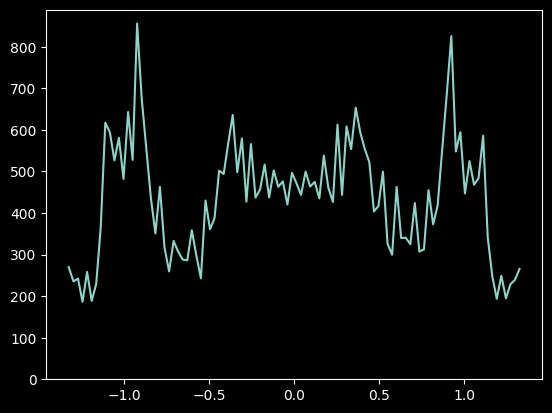

In [3]:
phi = np.linspace(0, 2*np.pi, 150)

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 80 * np.pi/180

# inclination of magnetic axis in radians relative to rotation axis
i_mag = 70 * np.pi/180

# latitude of the ring in radians
latitude = 60 * np.pi/180

# alpha=np.pi/3

# go through phi_bound

# fig, axes = plt.subplots(1,1,figsize=(10, 10))
# axes = axes.flatten()

fluxes = []
vs = []

for alpha in np.linspace(0, 2*np.pi,100):
    res = get_spectral_line(phi, i_rot, i_mag, latitude, alpha)
    print(alpha)
    phi_bounds, phi_bounds_v, signum, v_bounds_phi, v_bounds, flux, fluxmask, mask, v, phi, A, B, C = res

    fluxes.append((flux*fluxmask)[mask])
    vs.append(v[mask])

# make a dataframe from vs and fluxes
df = pd.DataFrame({'v': np.concatenate(vs), 'flux': np.concatenate(fluxes)})

# bin in v space and sum fluxes
df_binned = df.groupby(pd.cut(df.v, bins=100)).sum()

# plot
df_binned.index = pd.IntervalIndex(df_binned.index).mid

plt.plot(df_binned.index.values,  df_binned.flux.values)
plt.ylim(0,)

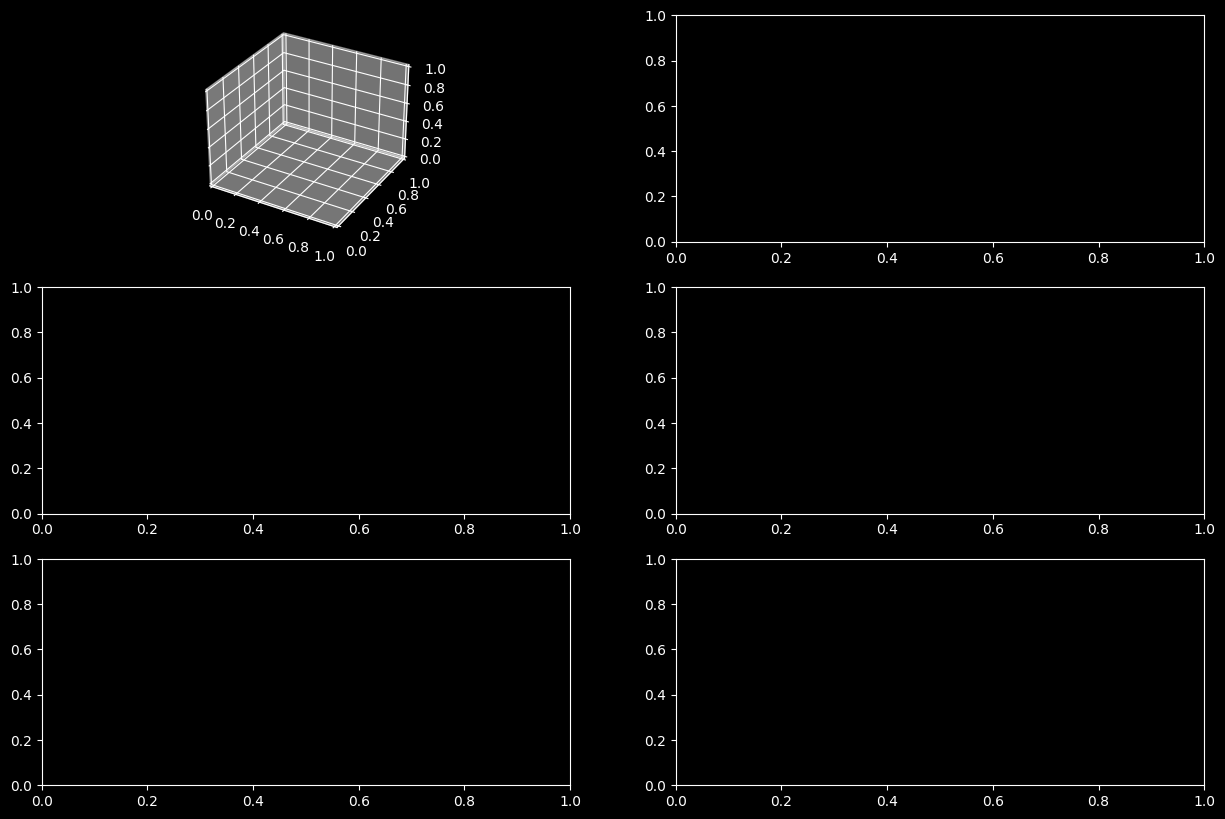

In [4]:
# set up a figure with six panels in a 3x2 grid, the first panel is in 3d projection
fig, axes = plt.subplots(3,2,figsize=(15, 10))
axes = axes.flatten()

# add the 3d projection to the top panel
ax = fig.add_subplot(321, projection='3d')

axes[0].set_axis_off()

ax2 = ax4

ax3 = ax5

## Archive

In [5]:

v = np.linspace(-5, 5, 200)

phi1, phi2 = phi_v(v, X, Y, Z)

plt.plot(v, phi1, linewidth=6, label=r'$\phi_1(v)$')
plt.plot(v, phi2, linewidth=4, label=r'$\phi_2(v)$')


phi = np.linspace(0, 2*np.pi, 100)

v1 = v_phi(phi, X, Y, Z)

plt.plot(v1, phi, linestyle='--', c="r", label=r'$v(\phi)$')

#fill between phi 5 and 5.5 horizontal
plt.fill_between(v, 5, 6, color='orange', alpha=0.4)
plt.fill_between(v, 0, 1.7, color='orange', alpha=0.4, label="integration bounds")


plt.xlabel(r'$v$')
plt.ylabel(r'$\phi$')
plt.legend(frameon=False, loc=(.5,.4), fontsize=14)
# plt.xlim(-3, 5)
plt.ylim(0, 2*np.pi);

NameError: name 'X' is not defined